<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/17_17_RF_32_modelsavefeatures_xxxx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import widgets
import os
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from rasterio.windows import Window
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from tqdm import tqdm
import time
import warnings

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")
drive.mount('/content/drive')

Please paste the path to your zip file from the sidebar: /content/drive/MyDrive/scraghbog.zip
Successfully unzipped to /content/dataset
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")
S_DSM = input("Summer DSM Path: ")
W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")
W_DSM = input("Winter DSM Path: ")
SHP_PATH = input("Shapefile (.shp) Path: ")

Summer RGB Path: /content/dataset/scraghbog/scraghbog_rgb_summer.tif
Summer NDVI Path: /content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif
Summer DSM Path: /content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif
Winter RGB Path: /content/dataset/scraghbog/Scraghbog_RGB_winter.tif
Winter NDVI Path: /content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif
Winter DSM Path: /content/dataset/scraghbog/Scraghbog_Winter_DSM.tif
Shapefile (.shp) Path: /content/dataset/scraghbog/scraghBog_habiMap.shp


In [5]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)


In [6]:
fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen', 'PF3': 'fen',
    'WD4': 'Tree & scrub', 'WN6': 'Tree & scrub', 'WN7': 'Tree & scrub',
    'FS1': 'Swamp/water', 'FS2': 'Swamp/water', 'FW2/WL2': 'Swamp/water'

}
gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

KERNEL = 17


In [7]:
def get_32_features(win_data, res):
    """Calculates 32 features with overflow protection and correct indexing."""
    eps = 1e-7

    # 1. Spectral Extraction
    # RGB means: Axis (1,2) on a (3, 17, 17) array returns [R, G, B]
    s_rgb = np.nanmean(win_data['s_rgb'], axis=(1, 2)).astype('float64')
    w_rgb = np.nanmean(win_data['w_rgb'], axis=(1, 2)).astype('float64')

    # Single band means: Returns scalar
    s_nd = np.clip(np.nanmean(win_data['s_ndvi']), -0.9, 0.9)
    w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)
    s_h = np.nanmean(win_data['s_dsm'])
    w_h = np.nanmean(win_data['w_dsm'])

    # 2. Synthetic NIR
    s_nir = s_rgb[0] * (1 + s_nd) / (1 - s_nd + eps)
    w_nir = w_rgb[0] * (1 + w_nd) / (1 - w_nd + eps)

    # 3. Advanced Indices Helper
    def calc_idx(r, g, b, nir):
        rvi = nir / (r + eps)
        savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
        evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
        gndvi = (nir - g) / (nir + g + eps)
        grvi = (g - r) / (g + r + eps)
        nrvi = (rvi - 1) / (rvi + 1 + eps)
        ndwi = (g - nir) / (g + nir + eps)
        vari = (g - r) / (g + r - b + eps)
        return np.clip([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari], -100, 100)

    s_idx = calc_idx(s_rgb[0], s_rgb[1], s_rgb[2], s_nir)
    w_idx = calc_idx(w_rgb[0], w_rgb[1], w_rgb[2], w_nir)

    # 4. Topography (Micro-structure)
    dsm = win_data['s_dsm'].astype('float64')
    dz_dy, dz_dx = np.gradient(dsm, res)
    slope = np.nanmean(np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))))
    roughness = np.nanstd(dsm)

    # 5. Final Stack
    features = np.concatenate([
        s_rgb, w_rgb,          # 1-6
        [s_nd, w_nd],          # 7-8
        [s_h, w_h],            # 9-10
        [s_nir, w_nir],        # 11-12
        s_idx, w_idx,          # 13-28
        [slope, roughness],    # 29-30
        [s_nd - w_nd],         # 31 (Delta NDVI)
        [s_h - w_h]            # 32 (Delta Height)
    ])
    return np.nan_to_num(features).astype('float32')


In [8]:
##TOO SLOW##

# X_list, y_list = [], []

# with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
#      rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
#      rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

#     res = sd.res[0]
#     gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
#     gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

#     print(f"Extracting 32 features from 1x1m blocks...")
#     for _, row in gdf.iterrows():
#         geom = row.geometry
#         b = geom.bounds
#         r1, c1 = sd.index(b[0], b[3])
#         r2, c2 = sd.index(b[2], b[1])

#         for r in range(r1, r2, KERNEL):
#             for c in range(c1, c2, KERNEL):
#                 win = Window(c, r, KERNEL, KERNEL)

#                 # Verify point is inside polygon
#                 center_pt = sd.xy(r + KERNEL//2, c + KERNEL//2)
#                 if not Point(center_pt).within(geom): continue

#                 data = {
#                     's_rgb': sr.read(window=win, boundless=True, fill_value=0),
#                     's_ndvi': sn.read(1, window=win, boundless=True, fill_value=0),
#                     's_dsm': sd.read(1, window=win, boundless=True, fill_value=0),
#                     'w_rgb': wr.read(window=win, boundless=True, fill_value=0),
#                     'w_ndvi': wn.read(1, window=win, boundless=True, fill_value=0),
#                     'w_dsm': wd.read(1, window=win, boundless=True, fill_value=0)
#                 }

#                 if np.max(data['s_rgb']) > 0:
#                     try:
#                         X_list.append(get_32_features(data, res))
#                         y_list.append(row['merged_name'])
#                     except: continue

# X, y = np.array(X_list), np.array(y_list)
# print(f"Dataset extracted: {len(X)} objects.")

In [9]:
import time
from tqdm import tqdm

X_list, y_list = [], []
start_time = time.time()

# 1. Open all files
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    res = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print(f"Starting Polygon-Chunked Extraction on {len(gdf)} polygons...")

    for _, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Polygons"):
        geom = row.geometry
        # Define the window for this specific polygon
        poly_window = rasterio.windows.from_bounds(*geom.bounds, transform=sd.transform)

        # Round the window to integer offsets to avoid slice errors
        poly_window = poly_window.round_offsets().round_shape()

        # --- THE SPEED SECRET: Read the whole polygon area into RAM ONCE ---
        try:
            s_rgb_p = sr.read(window=poly_window)
            s_nd_p  = sn.read(1, window=poly_window)
            s_dsm_p = sd.read(1, window=poly_window)
            w_rgb_p = wr.read(window=poly_window)
            w_nd_p  = wn.read(1, window=poly_window)
            w_dsm_p = wd.read(1, window=poly_window)
        except Exception as e:
            # Skip if window is invalid or outside raster bounds
            continue

        # Get local dimensions of this polygon chunk
        p_rows, p_cols = s_nd_p.shape
        # Create a transform local to this chunk for spatial checking
        chunk_transform = rasterio.windows.transform(poly_window, sd.transform)

        # Slice the RAM arrays
        for r in range(0, p_rows - KERNEL, KERNEL):
            for c in range(0, p_cols - KERNEL, KERNEL):

                # Spatial check using center point
                center_coords = chunk_transform * (c + KERNEL//2, r + KERNEL//2)

                if Point(center_coords).within(geom):
                    # Slice from the data already in RAM
                    data = {
                        's_rgb': s_rgb_p[:, r:r+KERNEL, c:c+KERNEL],
                        's_ndvi': s_nd_p[r:r+KERNEL, c:c+KERNEL],
                        's_dsm': s_dsm_p[r:r+KERNEL, c:c+KERNEL],
                        'w_rgb': w_rgb_p[:, r:r+KERNEL, c:c+KERNEL],
                        'w_ndvi': w_nd_p[r:r+KERNEL, c:c+KERNEL],
                        'w_dsm': w_dsm_p[r:r+KERNEL, c:c+KERNEL]
                    }

                    if np.max(data['s_rgb']) > 0:
                        try:
                            # Calculate features using CPU (very fast)
                            X_list.append(get_32_features(data, res))
                            y_list.append(row['merged_name'])
                        except:
                            continue

X, y = np.array(X_list), np.array(y_list)
print(f"\nExtraction complete: {len(X)} objects in {round((time.time()-start_time)/60, 2)}m")

Starting Polygon-Chunked Extraction on 18 polygons...


Polygons:   0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/rasterio/windows.py:729: RasterioDeprecationWarning: round_shape is deprecated and will be removed in Rasterio 2.0.0.
  warnings.warn(
/tmp/ipython-input-3628232037.py:12: RuntimeWarning: Mean of empty slice
  w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipython-input-3628232037.py:52: RuntimeWarning: overflow encountered in cast
  return np.nan_to_num(features).astype('float32')
Polygons: 100%|██████████| 18/18 [07:35<00:00, 25.32s/it]



Extraction complete: 449717 objects in 7.61m


In [14]:

# This uses your 500 trees and sqrt(M) but adds speed optimizations
rf = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',      # This is your M_var = sqrt(M)
    max_samples=0.2,          # MASSIVE speed boost: each tree sees 20% of data
    max_depth=20,             # Prevents trees from becoming infinitely deep
    class_weight='balanced',
    n_jobs=-1                 # Uses all your CPU cores
)


In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- UPDATED DATA CLEANING BLOCK ---
# 1. Cast to float64 immediately to prevent calculation overflow
X = X.astype(np.float64)

# 2. Handle Infs and NaNs
X[np.isinf(X)] = np.nan
col_means = np.nanmean(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_means, inds[1])

# 3. Scale the data (CRITICAL for large datasets)
# This keeps the values small so that rf internal math doesn't hit the ceiling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Final safety clip (Standardized data should be nowhere near 1e38)
X = np.clip(X, -1e10, 1e10)
# -----------------------------------

In [20]:

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report

# Use StratifiedKFold to maintain class ratios across folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Starting Cross-Validation on {X.shape[0]} samples...")

# Generate predictions
# We use n_jobs=1 here because the RF itself is already using n_jobs=-1
y_pred = cross_val_predict(rf, X, y, cv=kf)

print("\n--- 32-FEATURE K-FOLD REPORT ---")
print(classification_report(y, y_pred))

# Train the final model on the entire dataset
print("Training final model...")
rf.fit(X, y)
print("Model training complete!")


Starting Cross-Validation on 449717 samples...

--- 32-FEATURE K-FOLD REPORT ---
              precision    recall  f1-score   support

   Grassland       0.73      0.65      0.69     14230
 Swamp/water       0.73      0.78      0.75     52581
Tree & scrub       0.96      0.92      0.94    182707
         fen       0.90      0.92      0.91    200199

    accuracy                           0.90    449717
   macro avg       0.83      0.82      0.82    449717
weighted avg       0.90      0.90      0.90    449717

Training final model...
Model training complete!


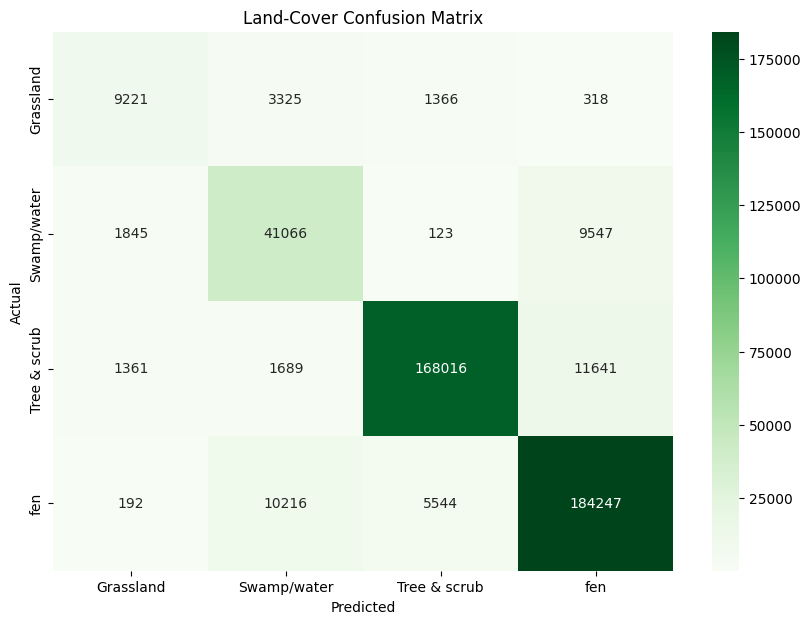

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Create the matrix
cm = confusion_matrix(y, y_pred)
labels = ['Grassland', 'Swamp/water', 'Tree & scrub', 'fen']

# 2. Plot it
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Land-Cover Confusion Matrix')
plt.show()

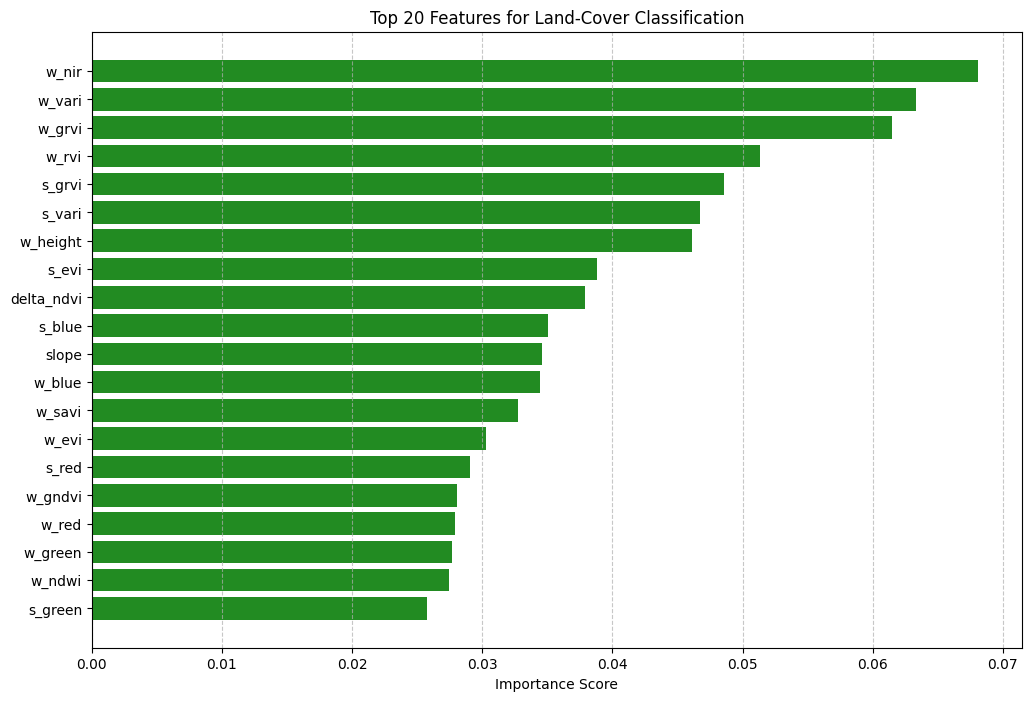

In [22]:

import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the importances from your trained model
importances = rf.feature_importances_

# 2. Use the list from above
feature_names = [
    "s_red", "s_green", "s_blue", "w_red", "w_green", "w_blue",
    "s_ndvi", "w_ndvi", "s_height", "w_height", "s_nir", "w_nir",
    "s_rvi", "s_savi", "s_evi", "s_gndvi", "s_grvi", "s_nrvi", "s_ndwi", "s_vari",
    "w_rvi", "w_savi", "w_evi", "w_gndvi", "w_grvi", "w_nrvi", "w_ndwi", "w_vari",
    "slope", "roughness", "delta_ndvi", "delta_height"
]

# 3. Create DataFrame and Plot
feat_import_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_import_df = feat_import_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
# Showing top 20 for better visibility
plt.barh(feat_import_df['Feature'][:20], feat_import_df['Importance'][:20], color='forestgreen')
plt.gca().invert_yaxis()
plt.title('Top 20 Features for Land-Cover Classification')
plt.xlabel('Importance Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [23]:

# import joblib

# # This saves it to the main folder of your Google Drive
# # You can change 'My Drive/land_cover_model.pkl' to include a specific folder if you want
# path = '/content/drive/My Drive/rf_model_17x17_kfold.pkl'

# joblib.dump(rf, path)

# print(f"Success! Your model is now safely stored in your Google Drive at: {path}")

Success! Your model is now safely stored in your Google Drive at: /content/drive/My Drive/rf_model_17x17_kfold.pkl
